In [157]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns

#可视化
sns.set(style='darkgrid',font_scale=1.3)

#设置图形参数
plt.rcParams['font.family']='SimHei'
plt.rcParams['axes.unicode_minus']=False


#特征工程
import sklearn
from sklearn import preprocessing                            #数据预处理模块
from sklearn.preprocessing import LabelEncoder               #编码转换
from sklearn.preprocessing import StandardScaler             #归一化
from sklearn.model_selection import StratifiedShuffleSplit   #分层抽样
from sklearn.model_selection import train_test_split         #数据分区
from sklearn.decomposition import PCA                        #主成分分析 （降维）


#分类算法
from sklearn.ensemble import RandomForestClassifier     #随机森林
from sklearn.svm import SVC,LinearSVC                   #支持向量机
from sklearn.linear_model import LogisticRegression     #逻辑回归
from sklearn.neighbors import KNeighborsClassifier      #KNN算法
from sklearn.cluster import KMeans                     #K-Means 聚类算法
from sklearn.naive_bayes import GaussianNB              #朴素贝叶斯
from sklearn.tree import DecisionTreeClassifier         #决策树


#分类算法-集成学习
import xgboost as xgb
from xgboost import XGBClassifier                      
from catboost import CatBoostClassifier                
from sklearn.ensemble import AdaBoostClassifier        
from sklearn.ensemble import GradientBoostingClassifier 



#模型评估
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score  #分类报告
from sklearn.metrics import confusion_matrix           #混淆矩阵
from sklearn.metrics import silhouette_score           #轮廓系数（评价k-mean聚类效果）
from sklearn.model_selection import GridSearchCV       #交叉验证
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingClassifier          #投票


#忽略警告
import warnings
warnings.filterwarnings('ignore')


#读取数据
df=pd.read_csv(r'Customer-Churn.csv',header=0)
#预览数据
df.head()
#查看数据大小
df.shape
#查看数据数据及分布
df.describe()


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [158]:
#数据清洗
#1.缺失值处理
#查看缺失值
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [106]:
#查看重复值
df.duplicated().sum()

0

In [159]:
#查看数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [160]:
#将TotalCharges数据类型转换为float
#总费用 TotalCharges  该列的数据类型应是float64，不是object
# df['TotalCharges'].astype('float64')
# 此处用“astype”转化数据类型报错 “could not convert string to float”
#改用强制转化 convert_numeric=True   
#df['TotalCharges']=df['TotalCharges'].convert_objects(convert_numeric=True)
df['TotalCharges']=df['TotalCharges'].apply(pd.to_numeric, errors="coerce")
df['TotalCharges'].dtype


#查看缺失值
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

<AxesSubplot:title={'center':'留存客户的总付费直方图'}, xlabel='TotalCharges', ylabel='Density'>

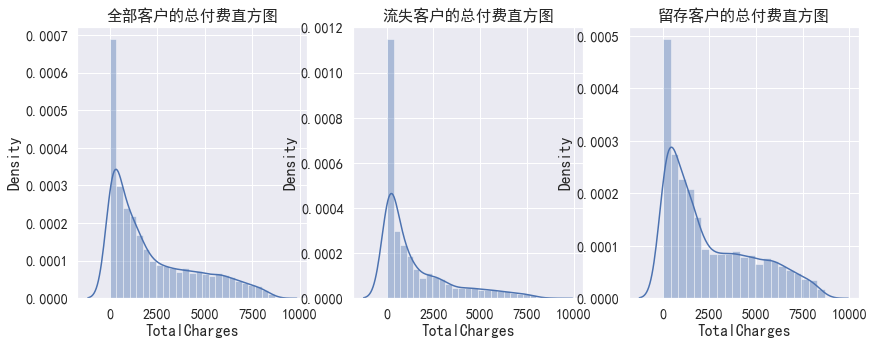

In [161]:
#出现缺失值，首先是尽量填充，最后才是删除
#缺失值处理规则：
#分类型数据：众数填充
#数值型数据：正态分布、均值/中位数填充；偏态分布、中位数填充
#缺失值为数值型数据，采用直方图查看数据分布

import matplotlib.pyplot as plt
#分别作直方图：全部客户类型、流失客户类型、留存客户类型
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.title('全部客户的总付费直方图')
sns.distplot(df['TotalCharges'].dropna())

plt.subplot(1,3,2)
plt.title('流失客户的总付费直方图')
sns.distplot(df[df['Churn']=='Yes']['TotalCharges'].dropna())

plt.subplot(1,3,3)
plt.title('留存客户的总付费直方图')
sns.distplot(df[df['Churn']=='No']['TotalCharges'].dropna())

In [162]:
#偏态分布，采用中位数填充
df.fillna({'TotalCharges':df['TotalCharges'].median()},inplace=True)
#再次确认是否还有空值
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [163]:
#对研究对象churn进行编码“Yes”=1，“No”=0
#方法一 replace：
#df['Churn'].replace(to_replace = 'Yes', value = 1,inplace = True)
#df['Churn'].replace(to_replace = 'No', value = 0,inplace = True)
#方法二：map函数
df['Churn']=df['Churn'].map({'Yes':1,'No':0})
#查看数据
df['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

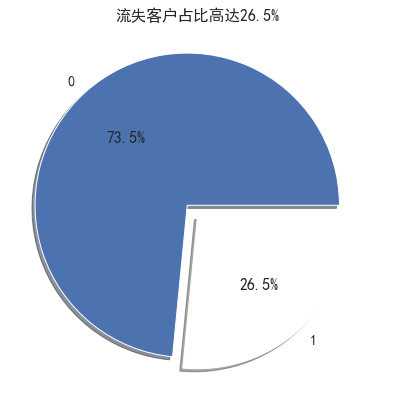

In [164]:
#查看流失客户占比
churn_value=df["Churn"].value_counts()
labels=df["Churn"].value_counts().index

plt.figure(figsize=(7,7))
plt.pie(churn_value,labels=labels,colors=["b","w"], explode=(0.1,0),autopct='%1.1f%%', shadow=True)
plt.title("流失客户占比高达26.5%")
plt.show()  

In [165]:
#【分析】：流失客户样本占比26.5%，留存客户样本占比73.5%，明显的“样本不均衡”。
#解决样本不均衡有以下方法可以选择：
#1.分层抽样
#2.过抽样
#3.欠抽样

#提取特征,去掉ID和目标churn
feature=df.iloc[:,1:20]
print(feature.info)

<bound method DataFrame.info of       gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No       1           No   
1       Male              0      No         No      34          Yes   
2       Male              0      No         No       2          Yes   
3       Male              0      No         No      45           No   
4     Female              0      No         No       2          Yes   
...      ...            ...     ...        ...     ...          ...   
7038    Male              0     Yes        Yes      24          Yes   
7039  Female              0     Yes        Yes      72          Yes   
7040  Female              0     Yes        Yes      11           No   
7041    Male              1     Yes         No       4          Yes   
7042    Male              0      No         No      66          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL       

In [166]:
#重新编码
#整数编码，查看变量间的两两相关性
#重新编码
corr_df = feature.apply(lambda x: pd.factorize(x)[0])
#corr_df.head()
#相关性矩阵
corr=corr_df.corr()
corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
gender,1.000000,-0.001874,0.001808,0.010517,-0.000013,-0.006488,-0.009451,-0.000863,-0.003429,0.012230,0.005092,0.000985,0.001156,-0.000191,0.000126,0.011754,-0.005209,-0.008072,-0.012302
SeniorCitizen,-0.001874,1.000000,-0.016479,-0.211185,0.010834,0.008576,0.113791,-0.032310,-0.210897,-0.144828,-0.157095,-0.223770,-0.130130,-0.120802,-0.142554,-0.156530,-0.093704,0.049649,0.023880
Partner,0.001808,-0.016479,1.000000,-0.452676,-0.101985,-0.017706,-0.117307,-0.000891,-0.081850,0.090753,-0.094451,-0.069072,-0.080127,-0.075779,-0.294806,-0.014877,-0.133115,-0.036054,-0.042628
Dependents,0.010517,-0.211185,-0.452676,1.000000,0.048514,-0.001762,-0.019657,0.044590,0.190523,0.062775,0.156439,0.180832,0.140395,0.125820,0.243187,0.111377,0.123844,-0.029390,0.006300
tenure,-0.000013,0.010834,-0.101985,0.048514,1.000000,-0.018799,0.063510,-0.012008,0.017083,-0.064613,0.037174,0.033108,0.027090,0.031491,0.122446,-0.011129,0.075379,0.041647,0.108142
PhoneService,-0.006488,0.008576,-0.017706,-0.001762,-0.018799,1.000000,0.675070,0.387436,0.125353,0.129770,0.138755,0.123350,0.171538,0.165205,0.002247,-0.016505,-0.004070,-0.141829,-0.029806
MultipleLines,-0.009451,0.113791,-0.117307,-0.019657,0.063510,0.675070,1.000000,0.186826,-0.066844,-0.130619,-0.013069,-0.066684,0.030195,0.028187,0.083343,-0.133255,0.025676,0.024338,0.015373
InternetService,-0.000863,-0.032310,-0.000891,0.044590,-0.012008,0.387436,0.186826,1.000000,0.607788,0.650962,0.662957,0.609795,0.712890,0.709020,0.099721,0.138625,0.008124,-0.289963,-0.038247
OnlineSecurity,-0.003429,-0.210897,-0.081850,0.190523,0.017083,0.125353,-0.066844,0.607788,1.000000,0.621739,0.749040,0.791225,0.701976,0.704984,0.389978,0.334003,0.213800,-0.220566,-0.026788
OnlineBackup,0.012230,-0.144828,0.090753,0.062775,-0.064613,0.129770,-0.130619,0.650962,0.621739,1.000000,0.601503,0.617003,0.604117,0.606863,0.035407,0.260715,0.003183,-0.284344,-0.054537


Text(0.5, 1.0, 'Correlation between variables')

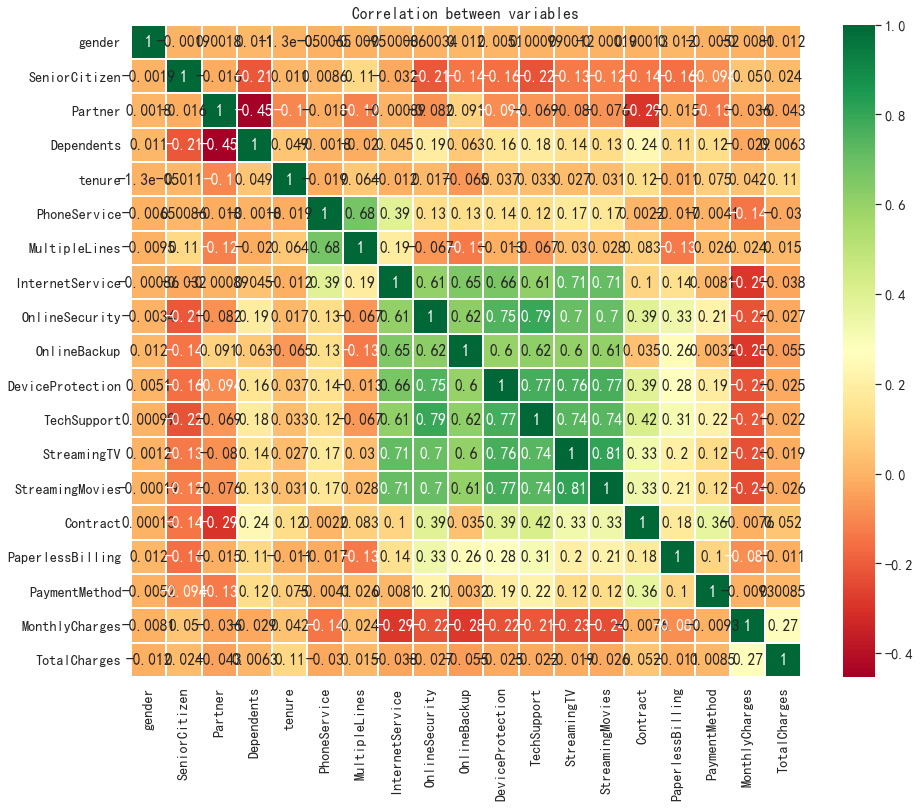

In [167]:
#绘制热力图观察变量之间的相关性强弱
plt.figure(figsize=(15,12))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=0.2, cmap="RdYlGn",annot=True)
plt.title("Correlation between variables")

In [168]:
#从热力图来看，互联网服务、网络安全、在线备份、
#设备维护服务、技术支持服务、开通网络电视服务、
#开通网络电影之间相关性很强，且是正相关。电话服务和多线业务之间也存在很强的正相关关系。


#查看研究对象"Churn"与其他变量下的标签相关性。独热编码，可以将分类变量下的标签转化成列
#独热编码
df_onehot = pd.get_dummies(df.iloc[:,1:21])
df_onehot.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


Text(0.5, 1.0, 'Correlation between Churn  and variables ')

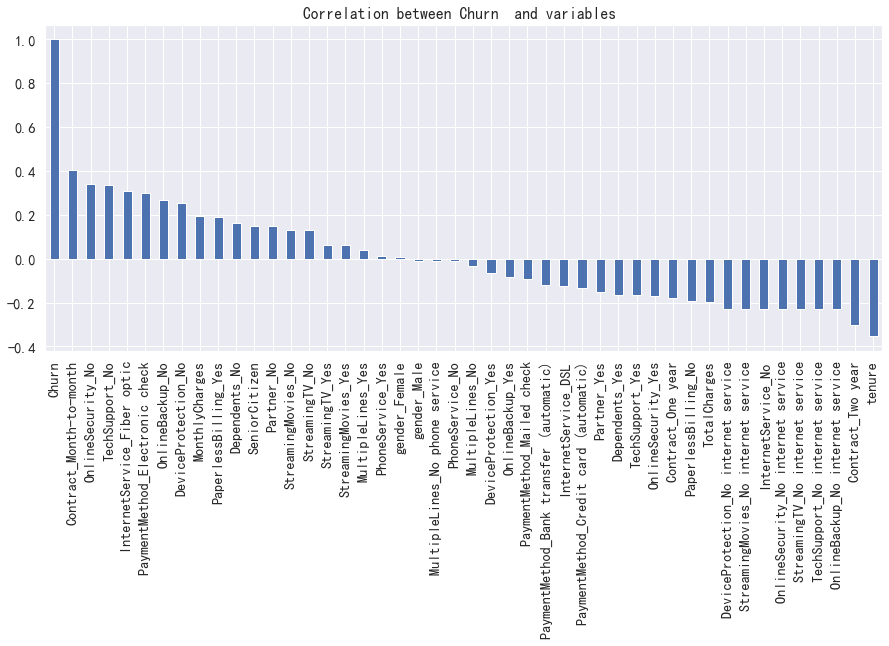

In [169]:
#绘图查看用户流失('Churn')与各个维度之间的关系
plt.figure(figsize=(15,6))
df_onehot.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation between Churn  and variables ')

In [170]:
#从图看gender（性别）、PhoneService（电话服务）相关性几乎为0，故两个维度可以忽略。
#['SeniorCitizen','Partner','Dependents', 'Contract',MultipleLines,'InternetService', 
#'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', '
#StreamingMovies','PaperlessBilling'，'PaymentMethod'] 等都有较高的相关性，
#将以上维度合并成一个列表kf_var，然后进行频数比较。

kf_var=list(df.columns[2:5])
for var in list(df.columns[7:18]):
    kf_var.append(var)
print('kf_var=',kf_var)

kf_var= ['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [171]:
#统计分析
#1.卡方检验
#组间有显著性差异，频数分布比较才有意义,否则可能会做无用功。
#"卡方检验",就是提高频数比较结论可信度的统计方法。
#分组间确实是有显著性差异，频数比较的结论才有可信度，故需进行”卡方检验“
from scipy.stats import chi2_contingency   #统计分析 卡方检验
#自定义卡方检验函数
def KF(x):
    df1=pd.crosstab(df['Churn'],df[x])
    li1=list(df1.iloc[0,:])
    li2=list(df1.iloc[1,:])
    kf_data=np.array([li1,li2])
    kf=chi2_contingency(kf_data)
    if kf[1]<0.05:
        print('Churn by {} 的卡方临界值是{:.2f}，小于0.05，表明{}组间有显著性差异,可进行【交叉分析】'.format(x,kf[1],x),'\n')
    else:
        print('Churn by {} 的卡方临界值是{:.2f}，大于0.05，表明{}组间无显著性差异,不可进行交叉分析'.format(x,kf[1],x),'\n')
#对 kf_var进行卡方检验
print('kf_var的卡方检验结果如下:','\n')
print(list(map(KF, kf_var)))

kf_var的卡方检验结果如下: 

Churn by SeniorCitizen 的卡方临界值是0.00，小于0.05，表明SeniorCitizen组间有显著性差异,可进行【交叉分析】 

Churn by Partner 的卡方临界值是0.00，小于0.05，表明Partner组间有显著性差异,可进行【交叉分析】 

Churn by Dependents 的卡方临界值是0.00，小于0.05，表明Dependents组间有显著性差异,可进行【交叉分析】 

Churn by MultipleLines 的卡方临界值是0.00，小于0.05，表明MultipleLines组间有显著性差异,可进行【交叉分析】 

Churn by InternetService 的卡方临界值是0.00，小于0.05，表明InternetService组间有显著性差异,可进行【交叉分析】 

Churn by OnlineSecurity 的卡方临界值是0.00，小于0.05，表明OnlineSecurity组间有显著性差异,可进行【交叉分析】 

Churn by OnlineBackup 的卡方临界值是0.00，小于0.05，表明OnlineBackup组间有显著性差异,可进行【交叉分析】 

Churn by DeviceProtection 的卡方临界值是0.00，小于0.05，表明DeviceProtection组间有显著性差异,可进行【交叉分析】 

Churn by TechSupport 的卡方临界值是0.00，小于0.05，表明TechSupport组间有显著性差异,可进行【交叉分析】 

Churn by StreamingTV 的卡方临界值是0.00，小于0.05，表明StreamingTV组间有显著性差异,可进行【交叉分析】 

Churn by StreamingMovies 的卡方临界值是0.00，小于0.05，表明StreamingMovies组间有显著性差异,可进行【交叉分析】 

Churn by Contract 的卡方临界值是0.00，小于0.05，表明Contract组间有显著性差异,可进行【交叉分析】 

Churn by PaperlessBilling 的卡方临界值是0.00，小于0.05，表明PaperlessBilling组间有显

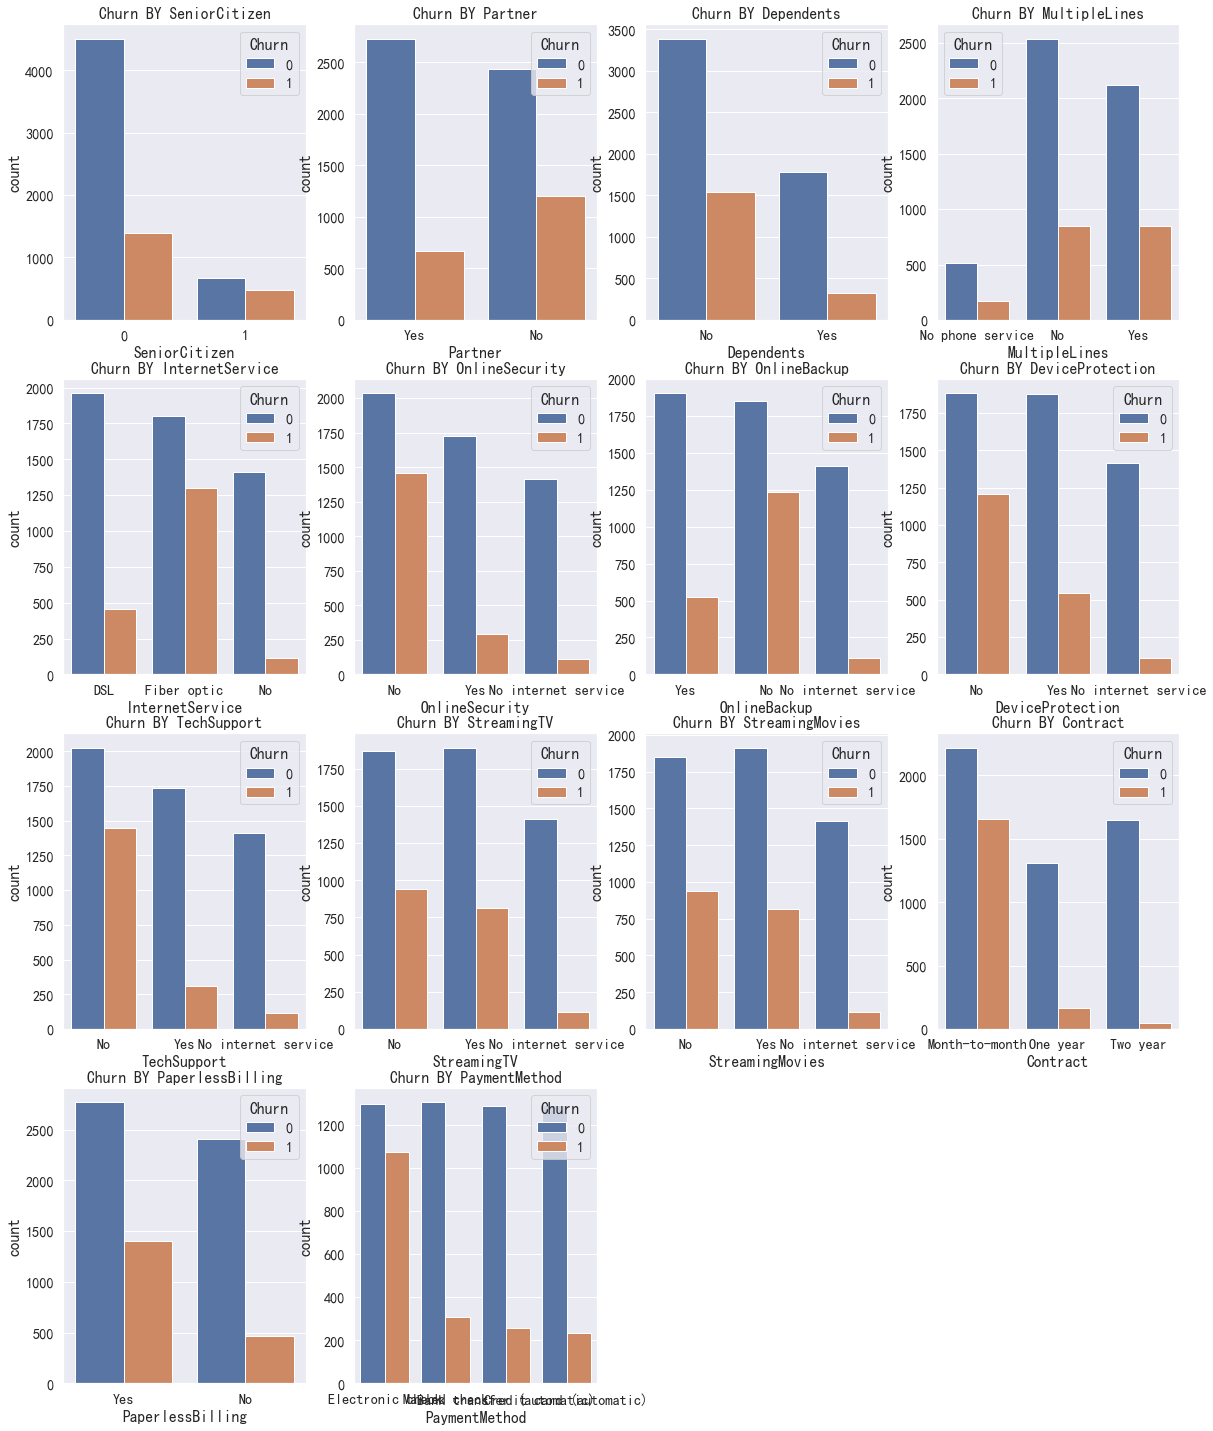

In [172]:
#从卡方检验的结果，kf_var包含的特征,组间都有显著性差异，可进行频数比较。
#频数比较，柱状图
plt.figure(figsize=(20,25))
a=0
for k in kf_var:
    a=a+1
    plt.subplot(4,4,a)
    plt.title('Churn BY '+ k)
    sns.countplot(x=k,hue='Churn',data=df)

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

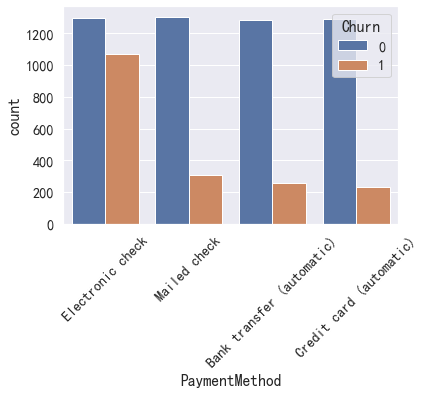

In [173]:
#因为PaymentMethod的标签比较长，影响看图，所以单独画。
plt.xticks(rotation=45)
sns.countplot(x='PaymentMethod',hue='Churn',data=df)

In [174]:
#可以直接从柱形图去判断对哪个维度对流失客户的影响大吗？
#不能，因为“样本不均衡”（流失客户样本占比26.5%，留存客户样本占比73.5%），
#基数不一样，故不能直接通过“频数”的柱形图去分析。解决办法：交叉分析，且作同行百分比（'Churn'作为“行”）

#交叉分析
print('ka_var列表中的维度与Churn交叉分析结果如下：','\n')
for i in kf_var:
    print('................Churn BY {}...............'.format(i))
    print(pd.crosstab(df['Churn'],df[i],normalize=0),'\n') #交叉分析，同行百分比
#ka_var列表中的维度与Churn交叉分析结果如下：
#【SeniorCitizen 分析】：年轻用户 在流失、留存，两个标签的人数占比都高。
#【Parter 分析】：单身用户更容易流失。
#【Denpendents 分析】：经济不独立的用户更容易流失。
#【MultipleLines 分析】：是否开通MultipleLines，对留存和流失都没有明显的促进作用。
#【InternetService 分析】：办理了 “Fiber optic 光纤网络”的客户容易流失。
#【OnlineBackup 分析】：没开通“在线备份服务”的客户容易流失
#【DeviceProtection 分析】：没开通“设备保护业务”的用户比较容易流失
#【TechSupport 分析】：没开通“技术支持服务”的用户容易流失。
#【StreamingTV 分析】：是否开通“网络电视”服务，对用户留存、流失，没有明显的促进作用。
#【StreamingMovies 分析】：是否开通“网络电影”服务，对用户留存、流失，没有明显的促进作用。
#【Contract 分析】逐月签订合同的用户最容易流失。
#【"Churn BY PaymentMethod"分析】使用“电子支票”支付的人更容易流失。

ka_var列表中的维度与Churn交叉分析结果如下： 

................Churn BY SeniorCitizen...............
SeniorCitizen         0         1
Churn                            
0              0.871279  0.128721
1              0.745318  0.254682 

................Churn BY Partner...............
Partner        No       Yes
Churn                      
0        0.471782  0.528218
1        0.642055  0.357945 

................Churn BY Dependents...............
Dependents        No       Yes
Churn                         
0           0.655199  0.344801
1           0.825575  0.174425 

................Churn BY MultipleLines...............
MultipleLines        No  No phone service       Yes
Churn                                              
0              0.491109          0.098956  0.409934
1              0.454254          0.090958  0.454789 

................Churn BY InternetService...............
InternetService       DSL  Fiber optic        No
Churn                                           
0                0.37

In [175]:
#均值比较
#组间有显著性差异，均值比较才有意义。
#显著性检验，先通过了齐性检验，再通过方差分析，最后才能做均值比较。
#齐性检验、方差分析
from scipy import stats
import scipy
def ANOVA(x):
    li_index=list(df['Churn'].value_counts().keys())
    args=[]
    for i in li_index:
        args.append(df[df['Churn']==i][x])
    w,p=scipy.stats.levene(*args)             #齐性检验
    if p<0.05:
        print('警告：Churn BY {}的P值为{:.2f}，小于0.05，表明齐性检验不通过，不可作方差分析'.format(x,p),'\n')
    else:
        f,p_value=stats.f_oneway(*args) #方差分析
        print('Churn BY {} 的f值是{},p_value值是{}'.format(x,f,p_value),'\n')
        if p_value<0.05:
            print('Churn BY {}的均值有显著性差异，可进行均值比较'.format(x),'\n')
        else:
            print('Churn BY {}的均值无显著性差异，不可进行均值比较'.format(x),'\n')

In [176]:
#对MonthlyCharges、TotalCharges维度分别进行齐性检验和方差分析
print('MonthlyCharges、TotalCharges的齐性检验 和方差分析结果如下:','\n')
ANOVA('MonthlyCharges')
ANOVA('TotalCharges')

MonthlyCharges、TotalCharges的齐性检验 和方差分析结果如下: 

警告：Churn BY MonthlyCharges的P值为0.00，小于0.05，表明齐性检验不通过，不可作方差分析 

警告：Churn BY TotalCharges的P值为0.00，小于0.05，表明齐性检验不通过，不可作方差分析 



In [184]:
#我们可以在SQL（数据库）上找有以上特征的客户，进行精准营销，
#即可以降低用户流失。虽然特征选得越多，越精确，但覆盖的人群也会越少。
#故，我们还需要计算“特征”的【重要性】，将最为重要的几个特征作为筛选条件。

#计算特征的【重要性】，是“分类视角”，接下来我们会挑选常见的分类模型，进行批量训练，
#然后挑出得分最高的模型，进一步计算“特征重要性”。

#特征提取
#有前面的流失率与各个维度的相关系数柱状图可知：
#流失率与gender（性别）、PhoneService（电话服务）相关性几乎为0，
#可以筛选掉，而customerID是随机数，不影响建模，故可以筛选掉。最终得到特征 churn_var
churn_var=df.iloc[:,2:20]
churn_var.drop("PhoneService",axis=1, inplace=True)
churn_var.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [92]:
#“MonthlyCharges"、"TotalCharges"两个特征跟其他特征相比，量纲差异大。
#处理量纲差异大，有两种方法：

#标准化
#离散化
#以上两种方法，哪个能让模型精度提高，就选哪个。根据模型的最后得分，我选了“离散化”来处理量纲差异大。

#标准化
scaler = StandardScaler(copy=False)
scaler.fit_transform(churn_var[['MonthlyCharges','TotalCharges']])  #fit_transform拟合数据
churn_var[['MonthlyCharges','TotalCharges']]=scaler.transform(churn_var[['MonthlyCharges','TotalCharges']])  #transform标准化

print(churn_var[['MonthlyCharges','TotalCharges']].head() )#查看拟合结果

   MonthlyCharges  TotalCharges
0       -1.160323     -0.994242
1       -0.259629     -0.173244
2       -0.362660     -0.959674
3       -0.746535     -0.194766
4        0.197365     -0.940470


In [185]:
#特征离散化
#特征离散化后，模型易于快速迭代，且模型更稳定。
#查看'MonthlyCharges'列的4分位
churn_var['MonthlyCharges'].describe() 

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [186]:
#离散操作 18.25=<churn_var['MonthlyCharges']<=35.5,标记 “1” 
#35.5<churn_var['MonthlyCharges']<=70.35,标记 “2” 
#70.35<churn_var['MonthlyCharges']<=89.85,标记 “3” 
#89.85=<churn_varf['MonthlyCharges']<=118.75，标记“4”

#查看'TotalCharges'列的4分位
churn_var['TotalCharges'].describe()

#用四分位数进行离散
churn_var['MonthlyCharges']=pd.qcut(churn_var['MonthlyCharges'],4,labels=['1','2','3','4'])
churn_var['MonthlyCharges'].head()

0    1
1    2
2    2
3    2
4    3
Name: MonthlyCharges, dtype: category
Categories (4, object): ['1' < '2' < '3' < '4']

In [187]:
#离散操作：18=<churn_var['TotalCharges']<=402,标记 “1”
#402<churn_var['TotalCharges']<=1397,标记 “2”
#1397<churn_var['TotalCharges']<=3786,标记 “3”
#3786<churn_var['TotalCharges']<=8684,标记 “4”

#用四分位数进行离散 
churn_var['TotalCharges']=pd.qcut(churn_var['TotalCharges'],4,labels=['1','2','3','4'])
churn_var['TotalCharges'].head()

0    1
1    3
2    1
3    3
4    1
Name: TotalCharges, dtype: category
Categories (4, object): ['1' < '2' < '3' < '4']

In [188]:
#将分类数据转换成“整数编码”
# 查看churn_var中分类变量的label(标签）
#自定义函数获取分类变量中的label
def Label(x):
    print(x,"--" ,churn_var[x].unique()) 
#筛选出数据类型为“object”的数据点
df_object=churn_var.select_dtypes(['object']) 
print(list(map(Label,df_object)))

Partner -- ['Yes' 'No']
Dependents -- ['No' 'Yes']
MultipleLines -- ['No phone service' 'No' 'Yes']
InternetService -- ['DSL' 'Fiber optic' 'No']
OnlineSecurity -- ['No' 'Yes' 'No internet service']
OnlineBackup -- ['Yes' 'No' 'No internet service']
DeviceProtection -- ['No' 'Yes' 'No internet service']
TechSupport -- ['No' 'Yes' 'No internet service']
StreamingTV -- ['No' 'Yes' 'No internet service']
StreamingMovies -- ['No' 'Yes' 'No internet service']
Contract -- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -- ['Yes' 'No']
PaymentMethod -- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
[None, None, None, None, None, None, None, None, None, None, None, None, None]


In [189]:
#通过同行百分比的“交叉分析”发现，
#label “No internetserive”的人数占比在以下特征[OnlineSecurity，OnlineBackup，DeviceProtection，
#TechSupport，StreamingTV，StreamingTV]都是惊人的一致，
#故我们可以判断label “No internetserive”不影响流失率。
#因为这6项增值服务，都是需要开通“互联网服务”的基础上才享受得到的。
#不开通“互联网服务”视为没开通这6项增值服务，故可以将 6个特正中的“No internetserive” 并到 “No”里面。
churn_var.replace(to_replace='No internet service',value='No',inplace=True)


#而特征MultipleLines的“ No phoneservice”在流失客户、留存客户样本中的人数占比几乎接近，
#且比较少，故可以将“ No phoneservice”并到“No”。
churn_var.replace(to_replace='No phone service',value='No',inplace=True)
df_object=churn_var.select_dtypes(['object']) 
print(list(map(Label,df_object.columns)))

Partner -- ['Yes' 'No']
Dependents -- ['No' 'Yes']
MultipleLines -- ['No' 'Yes']
InternetService -- ['DSL' 'Fiber optic' 'No']
OnlineSecurity -- ['No' 'Yes']
OnlineBackup -- ['Yes' 'No']
DeviceProtection -- ['No' 'Yes']
TechSupport -- ['No' 'Yes']
StreamingTV -- ['No' 'Yes']
StreamingMovies -- ['No' 'Yes']
Contract -- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -- ['Yes' 'No']
PaymentMethod -- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
[None, None, None, None, None, None, None, None, None, None, None, None, None]


In [190]:
#整数编码方式
#1、sklearn中的LabelEncoder()
#2、pandas中的factorize 此处选用 LabelEncoder()
def labelencode(x):
    churn_var[x] = LabelEncoder().fit_transform(churn_var[x])
for i in range(0,len(df_object.columns)):
    labelencode(df_object.columns[i])

print(list(map(Label,df_object.columns)))
#print(list(map(Label,churn_var.columns)))
#print(churn_var,df_object)

Partner -- [1 0]
Dependents -- [0 1]
MultipleLines -- [0 1]
InternetService -- [0 1 2]
OnlineSecurity -- [0 1]
OnlineBackup -- [1 0]
DeviceProtection -- [0 1]
TechSupport -- [0 1]
StreamingTV -- [0 1]
StreamingMovies -- [0 1]
Contract -- [0 1 2]
PaperlessBilling -- [1 0]
PaymentMethod -- [2 3 0 1]
[None, None, None, None, None, None, None, None, None, None, None, None, None]


In [192]:
#处理样本不均衡
#1.分拆变量
x=churn_var
y=df['Churn'].values
print('抽样前的数据特征',x.shape)
print('抽样前的数据标签',y.shape)

抽样前的数据特征 (7043, 17)
抽样前的数据标签 (7043,)


In [99]:
#处理样本不均衡常用的方式有三种：
#分层抽样
#过抽样
#欠抽样

#分层抽样
sss=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print(sss)
print("训练数据和测试数据被分成的组数：",sss.get_n_splits(x,y))
# 分拆训练集和测试集
for train_index, test_index in sss.split(x, y):
    print("train:", train_index, "test:", test_index)
    x_train,x_test=x.iloc[train_index], x.iloc[test_index]
    y_train,y_test=y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)
训练数据和测试数据被分成的组数： 5
train: [2499 5807 5118 ...  525 5748 6513] test: [5532 5173 7010 ... 6920 4696 2246]
train: [4996 2890 5709 ... 1546 3245 2928] test: [2015  868 5117 ...  550 5489  802]
train: [1695 4494 5164 ... 5963 2685 6386] test: [3303 3669  953 ... 5927 3078  880]
train: [5764 6926 2748 ... 3510  496 2656] test: [2714 3165 3010 ... 3153 3923 6120]
train: [4898 3058 2085 ... 6143  981 5287] test: [3080 4416 6547 ... 2551 4873 1388]


In [100]:
#过抽样
#“过抽样”让模型精度更高，故我选“过抽样”。
from imblearn.over_sampling import SMOTE
model_smote=SMOTE()
x,y=model_smote.fit_resample(x,y)
x=pd.DataFrame(x,columns=churn_var.columns)
#分拆数据集：训练集 和 测试集
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

In [101]:
#输出数据集大小
print('过抽样数据特征：', x.shape,
      '训练数据特征：',x_train.shape,
      '测试数据特征：',x_test.shape)

print('过抽样后数据标签：', y.shape,
      '   训练数据标签：',y_train.shape,
      '   测试数据标签：',y_test.shape)

过抽样数据特征： (10348, 17) 训练数据特征： (7243, 17) 测试数据特征： (3105, 17)
过抽样后数据标签： (10348,)    训练数据标签： (7243,)    测试数据标签： (3105,)


In [102]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
#数据建模
#使用分类算法
Classifiers=[["Random Forest",RandomForestClassifier()],
             ["Support Vector Machine",SVC()],
             ["LogisticRegression",LogisticRegression()],
             ["KNN",KNeighborsClassifier(n_neighbors=5)],
             ["Naive Bayes",GaussianNB()],
             ["Decision Tree",DecisionTreeClassifier()],
             ["AdaBoostClassifier", AdaBoostClassifier()],
             ["GradientBoostingClassifier", GradientBoostingClassifier()],
             ["XGB", XGBClassifier()],
             ["LightGBM", LGBMClassifier()],
             ["CatBoost", CatBoostClassifier(logging_level='Silent')]  
]
print(x_train,y_train)



      SeniorCitizen  Partner  Dependents  tenure  MultipleLines  \
9044              0        0           0      15              2   
9541              1        0           0       3              2   
5973              0        0           0      64              2   
9691              0        0           0      68              0   
7805              0        0           0       3              0   
...             ...      ...         ...     ...            ...   
9225              0        0           0      48              1   
4859              1        1           0      63              2   
3264              0        0           1      10              0   
9845              0        1           0      31              2   
2732              0        0           1       4              0   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
9044                0               0             0                 0   
9541                1               0            

In [134]:
#训练模型
Classify_result=[]
names=[]
prediction=[]
for name,classifier in Classifiers:
    classifier=classifier
    classifier.fit(x_train,y_train)
    y_pred=classifier.predict(x_test)
    recall=recall_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    f1score = f1_score(y_test, y_pred)
    class_eva=pd.DataFrame([recall,precision,f1score])
    Classify_result.append(class_eva)
    name=pd.Series(name)
    names.append(name)
    y_pred=pd.Series(y_pred)
    prediction.append(y_pred)
    
#模型评估
names=pd.DataFrame(names)
names=names[0].tolist()
result=pd.concat(Classify_result,axis=1)
result.columns=names
result.index=["recall","precision","f1score"]
result

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [135]:
#笔者尝试了两个算法分别输出“特征重要性”：CatBoost算法 和 XGB 算法
#catBoost
model = CatBoostClassifier()
model.fit(x_train,y_train,eval_set=(x_test, y_test),plot=True)
#特征重要性可视化
catboost=pd.DataFrame(columns=['feature','feature_importance'])
catboost['feature']=model.feature_names_
catboost['feature_importance']=model.feature_importances_
catboost=catboost.sort_values('feature_importance',ascending=False) #降序排列
plt.figure(figsize=(10,10))
plt.title('特征重要性')
sns.barplot(x='feature_importance',y='feature',data=catboost)

CatBoostError: features data: pandas.DataFrame column 'MonthlyCharges' has dtype 'category' but is not in  cat_features list

In [136]:
#xgb
model_xgb= XGBClassifier()
model_xgb.fit(x_train,y_train)
from xgboost import plot_importance
plot_importance(model_xgb,height=0.5)
plt.show()




ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.MonthlyCharges, TotalCharges

<AxesSubplot:xlabel='tenure', ylabel='count'>

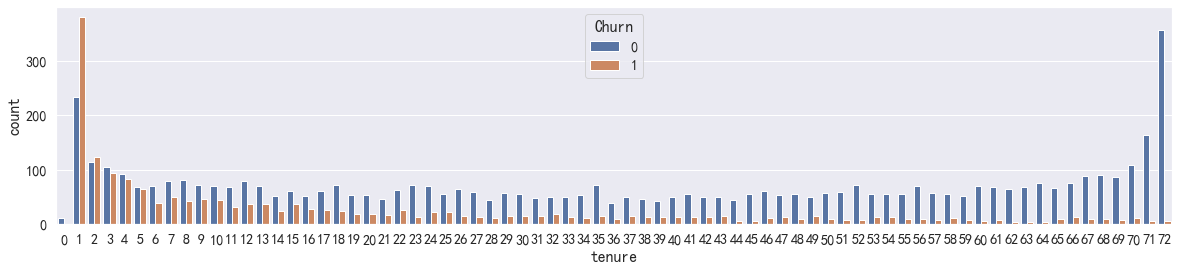

In [137]:
#由于 XGB算法精度得分最高，故我们以XGB得到的“特征重要性”进行分析。【分析】
#第一重要特征tenure
plt.figure(figsize=(20,4))
sns.countplot(x='tenure',hue='Churn',data=df)
#由图可知，流失客户集中在1-5号职位，运营团队需要重点关注1-5号职位。

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

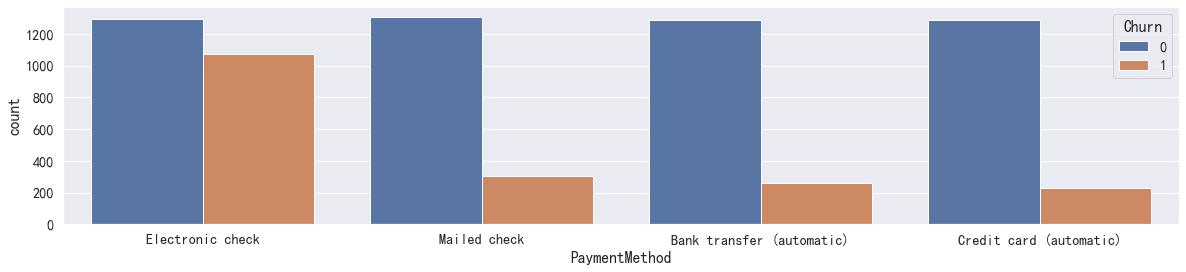

In [141]:
#第二重要特征：PaymentMethod【分析】 使用“电子支票”支付的人更容易流失。
plt.figure(figsize=(20,4))
sns.countplot(x='PaymentMethod',hue='Churn',data=df)

In [142]:
#第三重要特征：MonthlyCharges 查看流失用户、留存用户在付费方面的偏好：
#'MonthlyCharges'、'TotalCharges'，离散化后，可进行卡方检验，然后交叉分析。
#卡方检验：'MonthlyCharges'、'TotalCharges'
df['MonthlyCharges-']=churn_var['MonthlyCharges']
df['TotalCharges-']=churn_var['TotalCharges']
print('kf_var的卡方检验结果如下:','\n')
KF('MonthlyCharges-')
KF('TotalCharges-')

kf_var的卡方检验结果如下: 

Churn by MonthlyCharges- 的卡方临界值是0.00，小于0.05，表明MonthlyCharges-组间有显著性差异,可进行【交叉分析】 

Churn by TotalCharges- 的卡方临界值是0.00，小于0.05，表明TotalCharges-组间有显著性差异,可进行【交叉分析】 



In [143]:
#交叉分析
for i in ['MonthlyCharges','TotalCharges']:
    print('................Churn BY {}...............'.format(i))
    print(pd.crosstab(df['Churn'],df[i],normalize=0),'\n')

................Churn BY MonthlyCharges...............
MonthlyCharges    18.25     18.40     18.55     18.70     18.75     18.80   \
Churn                                                                        
0               0.000193  0.000193  0.000193  0.000387  0.000193  0.001353   
1               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

MonthlyCharges    18.85     18.90     18.95     19.00   ...    117.35  \
Churn                                                   ...             
0               0.000773  0.000387  0.000966  0.001160  ...  0.000193   
1               0.000535  0.000000  0.000535  0.000535  ...  0.000000   

MonthlyCharges    117.45    117.50    117.60    117.80    118.20    118.35  \
Churn                                                                        
0               0.000000  0.000193  0.000193  0.000000  0.000193  0.000000   
1               0.000535  0.000000  0.000000  0.000535  0.000000  0.000535   

MonthlyCharges    118.60  

In [144]:
#基于"MonthlyCharges"和“TotalCharges”画四分图：求两个维度的均值
 print('MonthlyCharges的均值是{:.2f},TotalCharges的均值是{:.2f}'.format(df['MonthlyCharges'].mea

IndentationError: unexpected indent (<ipython-input-144-8718313c52e4>, line 2)

In [145]:
#流失客户四分图：
#】 四分图的右下区域，流失客户比较集中，即总费用在2281.92元以下，
#月费用在64.76元以上的客户比较容易流失。
df_1=df[df['Churn']==1] #流失客户
df_0=df[df['Churn']==0] #留存客户
plt.figure(figsize=(10,10))   
sns.scatterplot('MonthlyCharges','TotalCharges',hue='Churn', palette=plt.cm.RdYlBu,data=df_1)
plt.axhline(y=df['TotalCharges'].mean(),ls="-",c="k")
plt.axvline(x=df['MonthlyCharges'].mean(),ls="-",c="green")

TypeError: 'LinearSegmentedColormap' object is not iterable

<Figure size 720x720 with 0 Axes>

In [146]:
#留存客户四分图
plt.figure(figsize=(10,10)) 
sns.scatterplot('MonthlyCharges','TotalCharges',hue='Churn', palette=plt.cm.RdYlBu_r,data=df_0)
plt.axhline(y=df['TotalCharges'].mean(),ls="-",c="k")
plt.axvline(x=df['MonthlyCharges'].mean(),ls="-",c="green")

TypeError: 'LinearSegmentedColormap' object is not iterable

<Figure size 720x720 with 0 Axes>